In [2]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np
import random
import os
os.environ['R_HOME'] = 'C:\Programming\R\R-4.4.2'

In [3]:
# 재현성 난수 고정
SEED = 100

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(SEED)
np.random.seed(SEED)

In [8]:
# data load
df_name_freesolv = 'freesolv'
df_name_esol = 'esol'
df_name_lipo = 'lipo'
df_name_pdbbind = 'pdbbind'

df_freesolv = pd.read_csv('C:\Programming\Github\EGCN\data\\' + df_name_freesolv + '.csv')
df_esol = pd.read_csv('C:\Programming\Github\EGCN\data\\' + df_name_esol + '.csv')
df_lipo = pd.read_csv('C:\Programming\Github\EGCN\data\\' + df_name_lipo + '.csv')
df_pdbbind = pd.read_csv('C:\Programming\Github\EGCN\data\\' + df_name_pdbbind + '.csv')

smiles_list_freesolv = df_freesolv['smiles'].tolist()
smiles_list_esol = df_esol['smiles'].tolist()
smiles_list_lipo = df_lipo['smiles'].tolist()
smiles_list_pdbbind = df_pdbbind['smiles'].tolist()

# target 정의
target_freesolv = df_freesolv.iloc[:,-1]
target_esol = df_esol.iloc[:,-1]
target_lipo = df_lipo.iloc[:,-1]
target_pdbbind = df_pdbbind.iloc[:,-1]

print(smiles_list_freesolv[:5])
print(smiles_list_esol[:5])
print(smiles_list_lipo[:5])
print(smiles_list_pdbbind[:5])

print(target_freesolv[:5])
print(target_esol[:5])
print(target_lipo[:5])
print(target_pdbbind[:5])

['CN(C)C(=O)c1ccc(cc1)OC', 'CS(=O)(=O)Cl', 'CC(C)C=C', 'CCc1cnccn1', 'CCCCCCCO']
['OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O', 'Cc1occc1C(=O)Nc2ccccc2', 'CC(C)=CCCC(C)=CC(=O)', 'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43', 'c1ccsc1']
['Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', 'COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23', 'COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl', 'OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(Cl)sc4[nH]3', 'Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)NCC#N)c1']
['CC(=O)NC(CCC(=O)[O-])C(=O)[O-]', 'C[NH2+]CCC(Oc1ccc(C(F)(F)F)cc1)c1ccccc1', 'CC(=O)N1CCCC(C)C1', 'Nc1cccc(C(=O)[O-])c1', 'CC(=O)Nc1nnc(S(N)(=O)=O)s1']
0   -11.01
1    -4.87
2     1.83
3    -5.45
4    -4.21
Name: freesolv, dtype: float64
0   -0.77
1   -3.30
2   -2.06
3   -7.87
4   -1.33
Name: logp, dtype: float64
0    3.54
1   -1.18
2    3.69
3    3.37
4    3.10
Name: lipo, dtype: float64
0    0.40
1    0.45
2    0.49
3    0.49
4    0.60
Name: binding affinity, dtype: float64


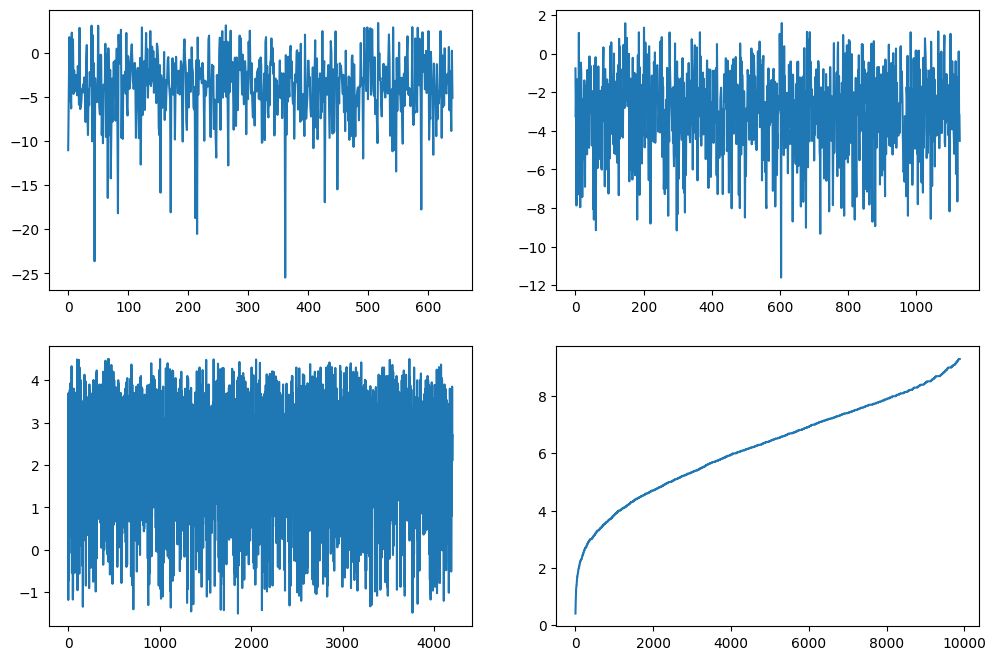

In [9]:
# 시각화
# 밀도 함수
import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))

plt.subplot(2,2,1)
plt.plot(target_freesolv)

plt.subplot(2,2,2)
plt.plot(target_esol)

plt.subplot(2,2,3)
plt.plot(target_lipo)

plt.subplot(2,2,4)
plt.plot(target_pdbbind)

plt.show()

In [ ]:
# freesolv
# 1
self_feats[i, 0] = mol_graph.NHOHCount
self_feats[i, 1] = mol_graph.SMR_VSA5
self_feats[i, 2] = mol_graph.SlogP_VSA2

# esol
# 1
self_feats[i, 0] = mol_graph.MolLogP
self_feats[i, 1] = mol_graph.SMR_VSA10
self_feats[i, 2] = mol_graph.MaxEStateIndex

# lipo
self_feats[i, 0] = mol_graph.fr_COO
self_feats[i, 1] = mol_graph.MolLogP
self_feats[i, 2] = mol_graph.NumAromaticHeterocycles

# pdbbind
# 1
self_feats[i, 0] = mol_graph.VSA_EState6
self_feats[i, 1] = mol_graph.Chi4n
self_feats[i, 2] = mol_graph.MolLogP